In [ ]:
%%capture
!pip install wradlib
!pip install opencv-python==3.4.2.16
!pip install opencv-contrib-python==3.4.2.16
!pip install pysteps==1.3.2
!git clone https://github.com/hydrogo/rainymotion.git
%cd rainymotion
!python setup.py install

In [ ]:
import time
import numpy as np
import matplotlib.pyplot as plt
from pysteps import motion
from pysteps import nowcasts
from pysteps import verification
from pysteps.utils import conversion, transformation
from pysteps.visualization import plot_precip_field, animate, quiver
import rainymotion
from rainymotion.models import SparseSD, DenseRotation
import cv2
cv2.__version__

Pysteps configuration file found at: /usr/local/lib/python3.6/dist-packages/pysteps/pystepsrc



'3.4.2'

In [ ]:
data = np.load("180709.npy")

In [ ]:
def dbz2rfl(d):
    return 10. ** (d / 10.)


def rfl2mmh(z, a=256., b=1.42):
    return (z / a) ** (1. / b)

Z = dbz2rfl(data)
R = rfl2mmh(Z, a=250., b=1.6)

In [ ]:
R_out = R.copy()
R_out[np.isnan(R)] = 0

In [ ]:
import matplotlib.animation as animation
from IPython.display import HTML
ims = []
fig = plt.figure(figsize=(6,6))

for i in range(R_out.shape[0]):
    im = plt.imshow(R_out[i, ...], vmin=0., vmax=2., cmap='cubehelix_r', animated=True, origin='lower')
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=200, blit=True, repeat_delay=1000)
plt.close(ani._fig)
HTML(ani.to_html5_video())

In [ ]:
from rainymotion.models import SparseSD, DenseRotation


model = DenseRotation()
R_used = R_out[0:7, ...]            # Select seventh data
R_valid = R_out[7:, ...]
model.input_data = R_used[-3:, :, :]       # Give just the last three frames for calculating velocity field      
model.lead_steps = 8
R_nowcast = model.run()

In [ ]:
R_nowcast.shape

(8, 1000, 1000)

In [ ]:
fig = plt.figure(figsize=(6,6))
ims = []
import matplotlib.animation as animation
from IPython.display import HTML
# R_used[:, np.isnan(R[0, ...])] = np.nan
# Data
for i in range(R_used.shape[0]):
    im = plt.imshow(R_used[i, ...], vmax=2, animated=True, origin='lower')      # Original data
    ims.append([im])

# Nowcasting
for i in range(8):
    im = plt.imshow(R_nowcast[i, ...], vmax=2, animated=True,origin='lower')    # Nowcasting 
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=200, blit=True, repeat_delay=1000)
plt.close(ani._fig)
HTML(ani.to_html5_video())

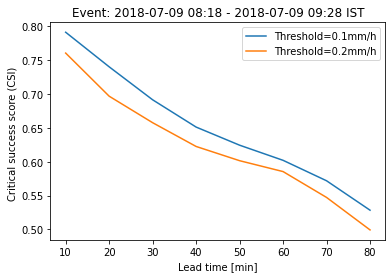

In [ ]:
timestep = 10     # Time interval in minutes
thr1 = 0.1        # Threshold for the method
thr2 = 0.2
score1 = []
score2 = []
# Dealing with NaN
R_nowcast[np.isnan(R_nowcast)] = 0
R [np.isnan(R)] = 0

for i in range(8):
    score1.append(rainymotion.metrics.CSI(R_nowcast[i, :, :], R[7 + i, :, :], threshold=thr1))
    score2.append(rainymotion.metrics.CSI(R_nowcast[i, :, :], R[7 + i, :, :], threshold=thr2))

plt.figure()
x = np.arange(1, 8 + 1) * timestep
plt.plot(x, score1,label='Threshold=0.1mm/h')
plt.plot(x, score2,label='Threshold=0.2mm/h')
plt.legend()
plt.xlabel("Lead time [min]")
plt.ylabel("Critical success score (CSI) ")
plt.title("Event: 2018-07-09 08:18 - 2018-07-09 09:28 IST")
plt.savefig("/content/drive/MyDrive/numpy files/9thJulyplots/CSI_9thJuly.png", dpi=300)
plt.show()

In [ ]:
metadata_mmh = {'institution': 'IITM', 'unit': 'mm/h', 'transform': None, 
                'accutime': 10.0, 'threshold': 0.0998518815125134, 
                'zerovalue': 0.0, 'yorigin': 'lower', 'x1': -200, 
                'y1': -200, 'x2': 200, 'y2': 200, 'xpixelsize': 1.0, 
                'ypixelsize': 1.0, 'zr_a': 200.0, 'zr_b': 1.6}

/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:452: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:459: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:464: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<string>:6: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


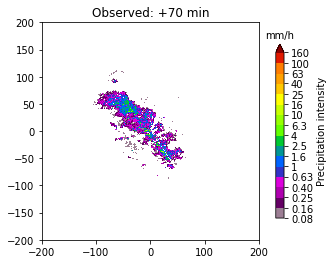

In [ ]:
plot_precip_field(R_valid[6], geodata=metadata_mmh,  axis="on", units='mm/h',
                  title='Observed: +70 min',colorbar=True)
plt.savefig("/content/drive/MyDrive/numpy files/9thJulyplots/obs7.png", dpi=300)